<a href="https://colab.research.google.com/github/sejin-sim/Math/blob/main/3_5_PCA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 기본 셋팅

In [7]:
import numpy as np

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({"axes.grid" : True})

plt.rcParams["figure.figsize"] = (12,6)
plt.rc("font", size=18)  # 그림의 폰트 크기를 18로 고정

gray = {"facecolor": "gray"}
black = {"facecolor": "black"}
red = {"facecolor": "red"}
green = {"facecolor": "green"}
blue = {"facecolor": "blue"}
lightgreen = {"facecolor": "lightgreen"}
gray = {"facecolor": "gray"}
black = {"facecolor": "black"}
red = {"facecolor": "red"}
green = {"facecolor": "green"}
blue = {"facecolor": "blue"}

np.random.seed(42)

# %config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


### 0) PCA
- 주성분 분석 (PCA) = 차원축소 : 고차원 데이터 집합이 주어졌을 때 원래의 고차원 데이터와 가장 비슷하면서 더 낮은 차원 데이터를 찾아내는 방법.
- 또는, 여러 변수 간에 존재하는 상관관계를 이용해 이를 대표한 주성분(Principal Component)을 추출해 차원을 축소하는 기법
- 아래 그림은 주성분을 찾기 위해 새로운 축을 찾아가는 과정이다.

<img src = "https://github.com/ExcelsiorCJH/Hands-On-ML/raw/eea2a029ec626854a972c24230de9053e1ece4af/Chap08-Dimensionality_Reduction/images/pca02.gif">

### 1) 붓꽃 데이터의 차원축소

1. 사이킷런의 붓꽃 데이터 중에서 10송이의 데이터, 즉 10개의 표본만 선택하여 꽃받침 길이와 꽃받침 폭 데이터를 그래프로 보이면 다음과 같다.

2. 첫 번째 그래프는 가로축을 특성의 종류, 세로축을 특성의 값으로 나타낸 것. 이 그래프에서 꽃받침 길이가 크면 꽃받침 폭도 같이 커진다는 규칙을 알 수 있다.
> 이유 : 꽃받침 길이 & 꽃받침 폭 2차원 측정 데이터는 사실 "꽃의 크기"라는 근본적인 데이터가 두 개의 다른 형태로 표현된 것이기 때문.

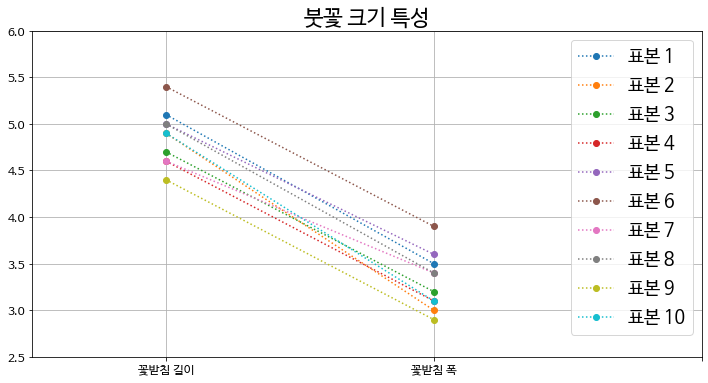

In [9]:
from sklearn.datasets import load_iris
iris = load_iris()
N = 10  # 앞의 10송이만 선택
X = iris.data[:N, :2]  # 꽃받침 길이와 꽃받침 폭만 선택

plt.plot(X.T, 'o:')
plt.xticks(range(4), ["꽃받침 길이", "꽃받침 폭"])
plt.xlim(-0.5, 2)
plt.ylim(2.5, 6)
plt.title("붓꽃 크기 특성")
plt.legend(["표본 {}".format(i + 1) for i in range(N)])
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


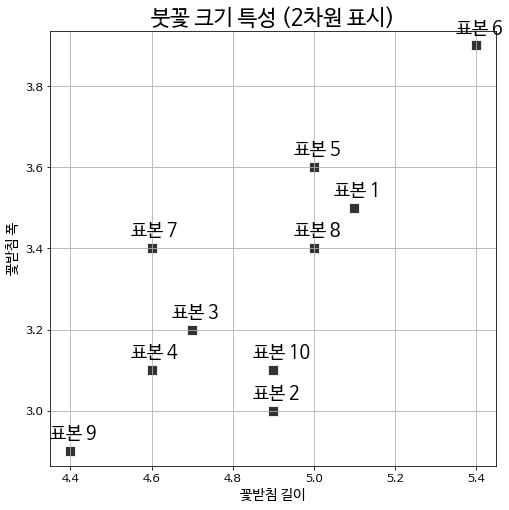

In [10]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(0, 1, data=pd.DataFrame(X), s=100, color=".2", marker="s")
for i in range(N):
    ax.text(X[i, 0] - 0.05, X[i, 1] + 0.03, "표본 {}".format(i + 1))
plt.xlabel("꽃받침 길이")
plt.ylabel("꽃받침 폭")
plt.title("붓꽃 크기 특성 (2차원 표시)")
plt.axis("equal")
plt.show()

3. PCA에서는 잠재변수와 측정 데이터가 선형적인 관계로 연결되어 있다고 가정한다. 
> $
\begin{align}
u_i = w^Tx_i
\end{align}
$
> - $u_i$ : 잠재변수, $w$ : 가중치 벡터
> - $x_i$ : $i$번째 표본의 측정 데이터 벡터

4. ex) 붓꽃의 선형 조합
> $
\begin{align}
u_i = w_1 x_{i,1} + w_2 x_{i,2}
\end{align}
$

5. ex) 스포츠 선수의 기록의 선형조합
> $
\begin{align}
\text{passer rating} = 
5 \cdot {\text{completions} \over \text{attempts}}
+ 0.25 \cdot {\text{passing yards} \over \text{attempts}}
+ 20 \cdot {\text{touchdowns} \over \text{attempts}} 
- 25 \cdot {\text{interceptions} \over \text{attempts}} + 0.125
\end{align}
$
> - 레이트(passer rate) : 점수
> - completions : 패스 성공 횟수, passing yards : 총 패싱 야드, touchdowns : 터치다운 횟수
> - interceptions : 인터셉션 횟수, attempts : 패스 시도 횟수
> - 선수의 실력(잠재변수)이 4개 수치의 선형조합으로 표현될 것이라고 가정.
> - 차원축소의 관점에서 보면 4차원의 데이터를 1차원으로 축소한 것.

### 2) 차원축소와 투영

1. 차원축소 : 다차원 벡터를 더 낮은 차원의 벡터공간에 투영하는 것 
> 즉, 특이분해에서 살펴본 로우-랭크 근사 문제와 동일

2. 로우-랭크 근사 문제
 - $N$개의 $M$차원 데이터 벡터 **$x_1, x_2, \cdots, x_N$**를 정규직교인 기저벡터 $w_1, w_2, \cdots, w_K$로 이루어진 **$K$차원 벡터공간으로 투영**하여 가장 비슷한 $N$개의 $K$차원 벡터 $x^{\Vert w}_1, x^{\Vert w}_2, \cdots, x^{\Vert w}_N$를 만들기 위한 **정규직교 기저벡터 $w_1, w_2, \cdots, w_K$**를 찾는다.    
 - 직선이 원점을 지난 다는 제한조건을 없애야 한다.(근사 성능을 높이기 위해)
 - $N$개의 $M$차원 데이터 벡터 $x_1, x_2, \cdots, x_N$에 대해 어떤 상수 벡터 $x_0$를 뺀 데이터 벡터  $x_1-x_0, x_2-x_0, \cdots, x_N-x_0$를 정규직교인 기저벡터 $w_1, w_2, \cdots, w_K$로 이루어진 $K$차원 벡터공간으로 투영하여 가장 비슷한 $N$개의 $K$차원 벡터 $x^{\Vert w}_1, x^{\Vert w}_2, \cdots, x^{\Vert w}_N$를 만들기 위한 정규직교 기저벡터 $w_1, w_2, \cdots, w_K$와 상수 벡터 $x_0$를 찾는다.

3. 문제의 답
> $x_0$는 데이터 벡터 $x_1, x_2, \cdots, x_N$의 평균벡터이고 $w_1, w_2, \cdots, w_K$는 가장 큰 $K$개의 특잇값에 대응하는 오른쪽 특이벡터 $v_1, v_2, \cdots, v_K$이다.


### 3) PCA의 수학적 설명

1. 특징 행렬 $x \in \mathbf{R}^{N\times M}$를 변환행렬 $W \in \mathbf{R}^{K \times M}$를 곱해서 차원축소 벡터 $\hat{x}$로 선형 변환하는 식.
 $$\hat{x}_i = W x_i$$    
$$x \in \mathbf{R}^M,\; W \in \mathbf{R}^{K \times M},\; \hat{x} \in \mathbf{R}^K$$

2. 모든 데이터 $x_i (i=1, \cdots, N)$에 대해 변환시 벡터를 행렬로 표현 가능
 $$\hat{X} = XW^{T}$$   
 $$ X \in \mathbf{R}^{N \times M},\; \hat{X} \in \mathbf{R}^{N \times K}, W^T \in \mathbf{R}^{M \times K}$$

3. PCA의 목표 : 변환 결과인 차원축소 벡터 $\hat{x}_i$의 정보가 원래의 벡터 $x_i$가 가졌던 정보와 가장 유사하게 되는 변환행렬 $W$값을 찾는 것
 - $x_i$의 차원 $\neq \hat{x}_i$ 차원 → 유사도를 비교할 수 없다. 
 - → $ \hat{x}_i$를 도로 M차원으로 선형 변형하는 역변환 행렬 U $\in \mathbf{R}^{M \times K}$도 같이 찾아야 한다.

4.  $M$차원으로 변환된 벡터 $\hat{\hat{x}}$
 $$\hat{\hat{x}} = U \hat{x}$$    
 $$\hat{x} \in \mathbf{R}^K,\; U \in \mathbf{R}^{M \times K},\; \hat{\hat{x}} \in \mathbf{R}^M$$   
 $$W \hat{\hat{x}} = W U \hat{x} = \hat{x}$$   
 $$WU = I$$

5.  역변환행렬 $U$을 알고 있다고 가정, 역변환 시 원래 벡터 $x$와 가장 비슷해지는 차원축소 벡터 $\hat{x}$를 다음과 같이 최적화를 이용하여 찾는다.

$$
\begin{align}
\arg\min_{\hat{x}} || x - U \hat{x} ||^2
\end{align}
$$

$$
\begin{align}
\begin{aligned}
|| x - U \hat{x} ||^2 
&= (x - U \hat{x})^T (x - U \hat{x}) \\
&= x^Tx - \hat{x}^T U^T {x}  - x^T U \hat{x} + \hat{x}^T U^T U \hat{x} \\
&= x^Tx - 2 x^T U \hat{x} + \hat{x}^T  \hat{x} \\
\end{aligned}
\end{align}
$$

6. 목적함수를 최소화하려면 $\hat{x}$로 미분한 식이 영벡터가 되는 값을 찾아야 한다. 위 목적함수를 미분한 식은 다음과 같다.

$$
\begin{align}
- 2 U^Tx + 2\hat{x} = 0
\end{align}
$$
$$
\begin{align}
\hat{x} = U^Tx  = Wx
\end{align}
$$
$$
\begin{align}
U = W^{T}
\end{align}
$$
$$
\begin{align}
WW^{T} = I
\end{align}
$$


7. 최적의 변환 행렬 $W$을 찾는 최적화 문제는 다음과 같다.

$$
\begin{align}
\arg\min_{W} \sum_{i=1}^N || x_i - W^{T} W x_i ||^2
\end{align}
$$
$$
\begin{align}
\arg\min_{W} || X - X W^{T} W ||^2
\end{align}
$$

- 이 문제는 랭크-$K$ 근사문제이므로 $W$는 가장 큰  $K$개의 특잇값에 대응하는 오른쪽 특이벡터로 만들어진 행렬이다.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


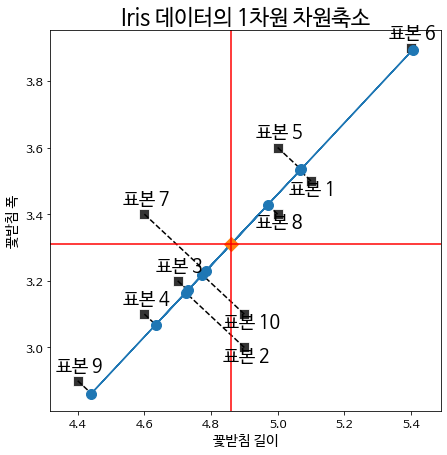

In [11]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=1)         # 2 → 1차원으로
X_low = pca1.fit_transform(X)      # 변환
X2 = pca1.inverse_transform(X_low) # 2차원으로 복귀

plt.figure(figsize=(7, 7))
ax = sns.scatterplot(0, 1, data=pd.DataFrame(X), s=100, color=".2", marker="s")
for i in range(N):
    d = 0.03 if X[i, 1] > X2[i, 1] else -0.04
    ax.text(X[i, 0] - 0.065, X[i, 1] + d, "표본 {}".format(i + 1))
    plt.plot([X[i, 0], X2[i, 0]], [X[i, 1], X2[i, 1]], "k--")
plt.plot(X2[:, 0], X2[:, 1], "o-", markersize=10)
plt.plot(X[:, 0].mean(), X[:, 1].mean(), markersize=10, marker="D")
plt.axvline(X[:, 0].mean(), c='r')
plt.axhline(X[:, 1].mean(), c='r')
plt.grid(False)
plt.xlabel("꽃받침 길이")
plt.ylabel("꽃받침 폭")
plt.title("Iris 데이터의 1차원 차원축소")
plt.axis("equal")
plt.show()

In [12]:
pca1.mean_       # 데이터의 평균값은

array([4.86, 3.31])

In [13]:
pca1.components_ # 성분 벡터 즉, 가장 근사 데이터를 만드는 단위기저벡터

array([[0.68305029, 0.73037134]])

In [15]:
X0 = X - X.mean(axis=0)
U, S, VT = np.linalg.svd(X0)
VT[:, 0] # 첫 번째 오른쪽 특이벡터

array([-0.68305029, -0.73037134])

In [18]:
XCOV = X0.T @ X0
W, V = np.linalg.eig(XCOV)
print(W)
print(V)
print(V[:, np.argmax(W)])

[0.17107711 1.44192289]
[[-0.73037134 -0.68305029]
 [ 0.68305029 -0.73037134]]
[-0.68305029 -0.73037134]


In [20]:
print(X[7, :])    # 8번째 꽃의 꽃받침 길이와 꽃받침 폭
print(X_low[7])   # PCA로 구한 주성분의 값 즉, 꽃의 크기
print(pca1.components_ @ (X[7, :] - pca1.mean_))
print(X2[7, :])   # 주성분의 값을 이용하여 다시 2차원 값으로 나타낸 근사값

[5.  3.4]
[0.16136046]
[0.16136046]
[4.97021731 3.42785306]


#### 연습 문제 3.5.1

붓꽃 데이터 중 앞에서 50개의 데이터(setosa 종)에 대해 다음 문제를 풀어라.

(1) 꽃잎의 길이와 꽃잎의 폭을 이용하여 1차원 PCA를 수행하라. 꽃의 크기는 꽃받침 길이와 꽃받침 폭의 어떤 선형조합으로 나타나는가?

(2) 꽃받침 길이와 폭, 꽃잎 길이와 폭, 이 4가지 변수를 모두 사용하여 1차원 PCA를 수행하라. 꽃의 크기는 관측 데이터의 어떤 선형조합으로 나타나는가?

In [34]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

X = load_iris().data
pca = PCA(n_components=1)         # 2 → 1차원으로
pca.fit_transform(X[:50, :2])      # 변환

print("1) 꽃의 크기 = ", pca.components_)

pca = PCA(n_components=1)
pca.fit_transform(X[:50, :4])     # 변환

print("2) 꽃의 크기 = ",pcaA.components_)

1) 꽃의 크기 =  [[0.67174957 0.74077832]]
2) 꽃의 크기 =  [[0.6690784  0.73414783 0.0965439  0.06356359]]


### 4) 이미지 PCA

- 사람의 얼굴 데이터를 PCA로 분석하자. 올리베티 얼굴 사진 중 특정 인물의 사진 10장을 데이터로 사용한다.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


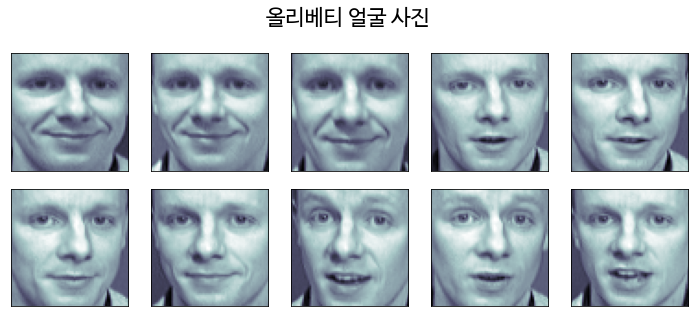

In [35]:
from sklearn.datasets import fetch_olivetti_faces

faces_all = fetch_olivetti_faces()
K = 20  # 20번 인물의 사진만 선택
faces = faces_all.images[faces_all.target == K]

N = 2
M = 5
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(faces[k], cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.suptitle("올리베티 얼굴 사진")
plt.tight_layout()
plt.show()

- 주성분이 2개인 PCA 분석 후 근사화 하면 결과는 다음과 같다.

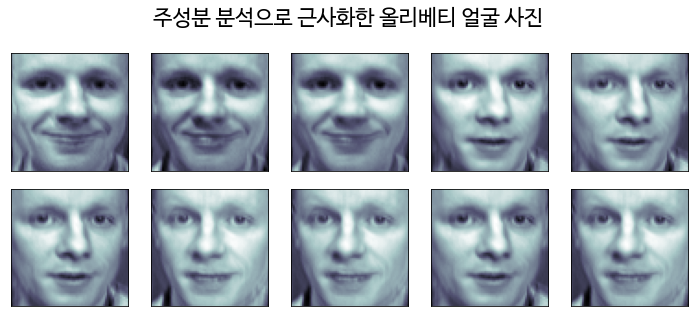

In [37]:
from sklearn.decomposition import PCA
pca3 = PCA(n_components=2)
X3 = faces_all.data[faces_all.target == K]
W3 = pca3.fit_transform(X3)
X32 = pca3.inverse_transform(W3)

N = 2
M = 5
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(X32[k].reshape(64, 64), cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.suptitle("주성분 분석으로 근사화한 올리베티 얼굴 사진")
plt.tight_layout()
plt.show()

- 평균값과 2개의 주성분 얼굴의 각기 다른 선형조합이다.
- 평균값과 2개의 주성분이 나타내는 얼굴을 이미지로 표시하면 다음과 같다. 
- 주성분이 나타내는 얼굴을 아이겐페이스(Eigen Face)라고도 한다.

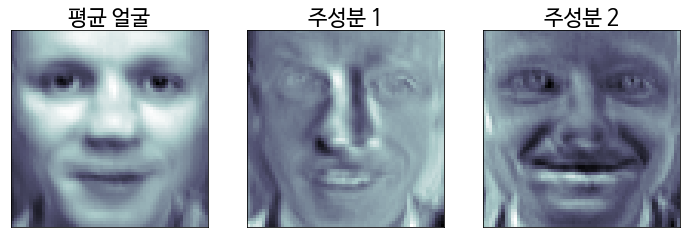

In [38]:
face_mean = pca3.mean_.reshape(64, 64)
face_p1 = pca3.components_[0].reshape(64, 64)
face_p2 = pca3.components_[1].reshape(64, 64)

plt.subplot(131)
plt.imshow(face_mean, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("평균 얼굴")
plt.subplot(132)
plt.imshow(face_p1, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("주성분 1")
plt.subplot(133)
plt.imshow(face_p2, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("주성분 2")
plt.show()

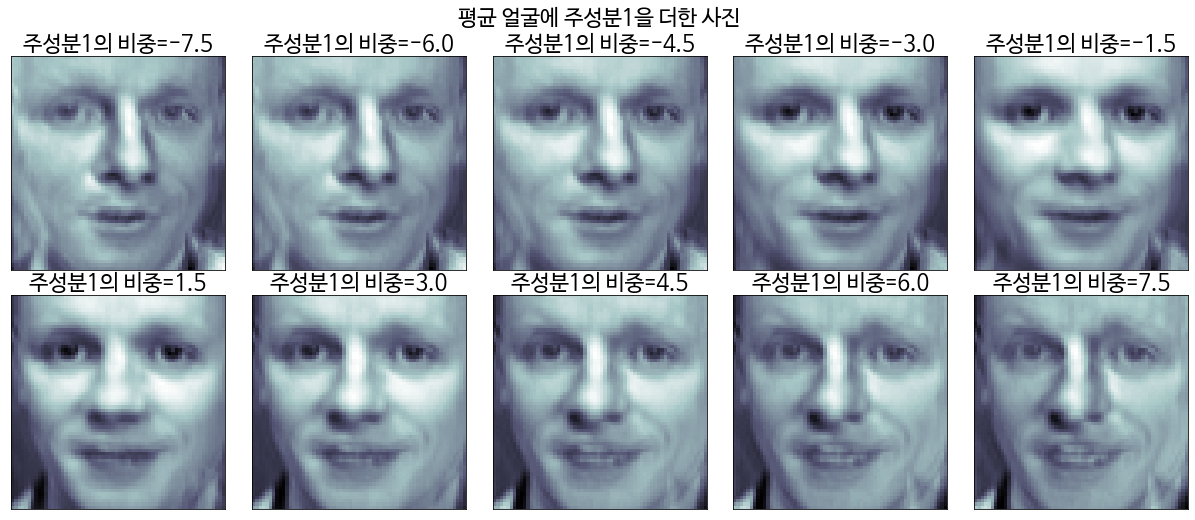

In [45]:
N = 2
M = 5
fig = plt.figure(figsize=(17, 8))

plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        w = 1.5 * (k - 5) if k < 5 else 1.5 * (k - 4)
        ax.imshow(face_mean + w * face_p1, cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title("주성분1의 비중={}".format(w))
plt.suptitle("평균 얼굴에 주성분1을 더한 사진")
plt.tight_layout()
plt.show()

- 첫 번째 주성분은 왼쪽과 오른쪽에서 바라본 얼굴 이미지의 차이를 나타낸다는 것을 알 수 있다.

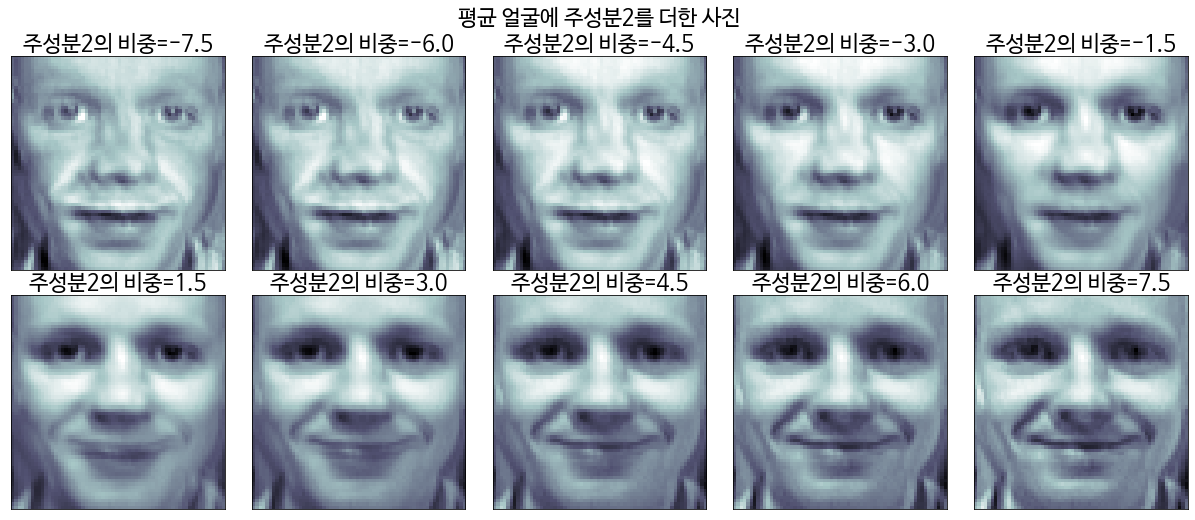

In [47]:
N = 2
M = 5
fig = plt.figure(figsize=(17, 8))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        w = 1.5 * (k - 5) if k < 5 else 1.5 * (k - 4)
        ax.imshow(face_mean + w * face_p2, cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title("주성분2의 비중={:.1f}".format(w))
plt.suptitle("평균 얼굴에 주성분2를 더한 사진")
plt.tight_layout()
plt.show()

- 두 번째 주성분은 미소짓는 얼굴과 그렇지 않은 얼굴 이미지의 차이를 나타낸다는 것을 알 수 있다.

### 5) 주식 가격의 PCA

- 금융분야에서 PCA가### 5) 주식 가격의 PCA

- 금융분야에서 PCA가 어떻게 쓰이는지 알아보자. 우선 미국(US), 일본(JP), 유럽(EZ), 한국(KR)의 과거 20년간 주가를 살펴보자. 어떻게 쓰이는지 알아보자. 우선 미국(US), 일본(JP), 유럽(EZ), 한국(KR)의 과거 20년간 주가를 살펴보자.

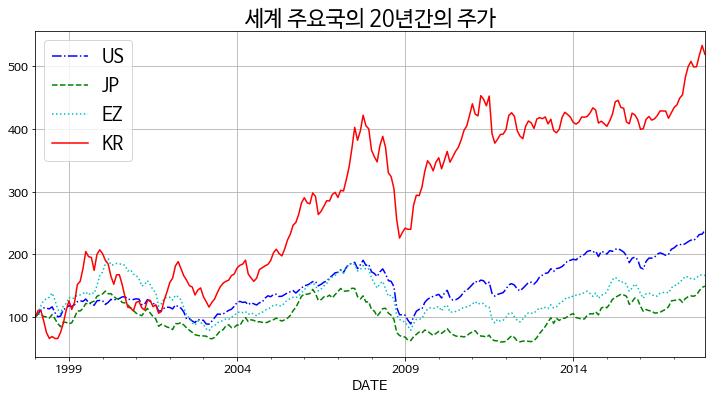

In [48]:
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime

symbols = [
    "SPASTT01USM661N", # US: 미국
    "SPASTT01JPM661N", # JP: 일본
    "SPASTT01EZM661N", # EZ: 유럽
    "SPASTT01KRM661N", # KR: 한국
]

data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='fred', 
                               start=datetime.datetime(1998, 1, 1),
                               end=datetime.datetime(2017, 12, 31))[sym]
data.columns = ["US", "JP", "EZ", "KR"]
data = data / data.iloc[0] * 100

styles = ["b-.", "g--", "c:", "r-"]
data.plot(style=styles)
plt.title("세계 주요국의 20년간의 주가")
plt.show()

시작시점의 주가가 100이 되도록 크기를 조정하고, 연간 주식수익률 데이터를 구하면 다음처럼 $20 \times 4$ 크기의 특징행렬을 구할 수 있다.

In [49]:
df = ((data.pct_change() + 1).resample("A").prod() - 1).T * 100
print(df.iloc[:, :5])

DATE  1998-12-31  1999-12-31  2000-12-31  2001-12-31  2002-12-31
US     14.249290   10.800392    1.094171   -9.638213  -17.680773
JP     -8.567915   47.802619  -18.365577  -23.827406  -16.923968
EZ     21.308040   36.872314    1.375330  -21.857080  -30.647772
KR     10.411582   87.623876  -46.975114   27.644005    4.448180


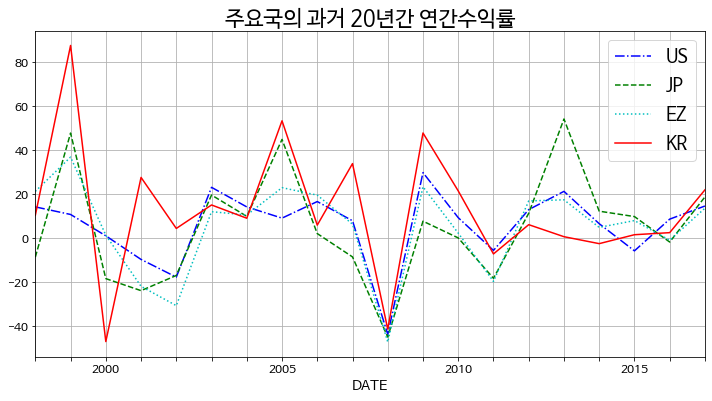

In [50]:
df.T.plot(style=styles)
plt.title("주요국의 과거 20년간 연간수익률")
plt.xticks(df.columns)
plt.show()

- 각 표본이 가지는 측정 데이터 벡터의 모양(비율)이 비슷하다.
- 각 나라의 수익률은 "경제적 요인"이라고 하는 공통된 잠재변수에 의해서 결정되기 때문이다.
-  PCA 분석을 통해 모든 나라의 주가 움직임 기저에 깔려있는 성분을 살펴보자.


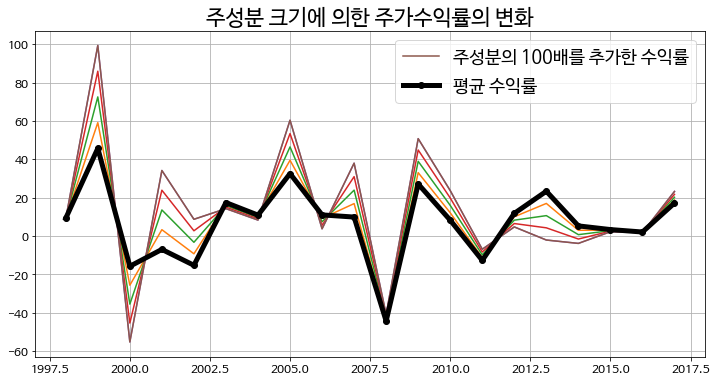

In [51]:
pca2 = PCA(n_components=1)
w = pca2.fit_transform(df)

m = pca2.mean_             # 세계주가의 공통요인
p1 = pca2.components_[0]   # 나라별로 주가를 다르게 하는 요인

xrange = np.linspace(1998, 2017, 20, dtype=int)
for i in np.linspace(0, 100, 5):
    plt.plot(xrange, pca2.mean_ + p1 * i)
plt.plot(xrange, pca2.mean_ + p1 * 100, label="주성분의 100배를 추가한 수익률")
plt.plot(xrange, pca2.mean_, "ko-", lw=5, label="평균 수익률")
plt.title("주성분 크기에 의한 주가수익률의 변화")
plt.legend()
plt.show()

In [52]:
df_w = pd.DataFrame(w)
df_w.index = df.index
df_w.columns = ["주성분 비중"]
print(df_w)

       주성분 비중
US -33.413784
JP -20.943197
EZ -26.917702
KR  81.274683


- 한국은 주성분의 비중이 80이 넘고, 나머지 국가들은 모두 주성분의 성분이 음수. 또한 주성분을 이용하여 구한 근사 주가를 표시하면 다음과 같다

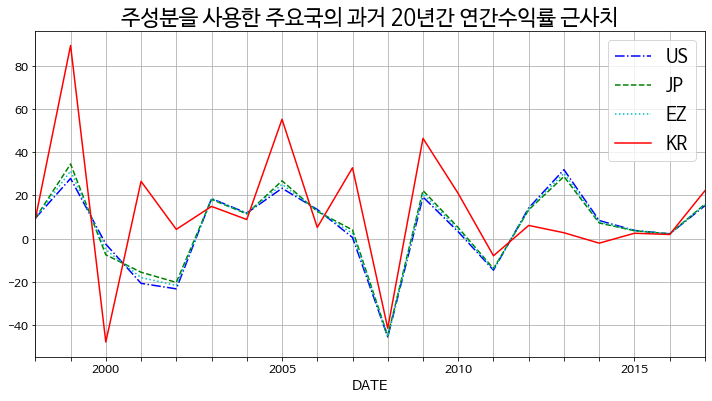

In [53]:
df_i = pd.DataFrame(pca2.inverse_transform(w))
df_i.index = df.index
df_i.columns = df.columns
df_i.iloc[:, -10:]
df_i.T.plot(style=styles)
plt.title("주성분을 사용한 주요국의 과거 20년간 연간수익률 근사치")
plt.xticks(df.columns)
plt.show()

- 우리가 구한 주성분은 '미국, 일본, 유럽'이라는 데이터로부터 '한국'이라는 데이터로 변화시키는 요인, 즉 중진국 요인이라 부를 수 있는 성분이라는 것을 명확하게 알 수 있다.